# How to trick Inception v3

This notebook repackages code from the great article: `https://medium.com/@ageitgey/machine-learning-is-fun-part-8-how-to-intentionally-trick-neural-networks-b55da32b7196`. Please go and read it and make sure you "clap" at the bottom. (I just made a change that may speed up convergence.)

The idea here is to take an image (in our case of a Persian cat, but anything else might work, even noise), pick a class out of the 1000 defined by the ImageNet data set, and **generate an imperceptibly different image that is classified with high confidence as belonging to the arbitrarily chosen class**.

So, you can fool the classifier to see, instead of a cat, a screwdriver or a yurt or an espresso, you name it.

I needed an interactive notebook because I wanted to be able to demonstrate quickly and convincingly how easy it is to tweak imperceptibly an image so that a "state-of-the-art" deep learning classifier mistakes any image (here a Persian cat) for any class that one might choose.

This helps to put deep learning into perspective. When shown this, people immediately realize that the "deep learning" narrative of "layers building more complex representations on top of each other" should be interpreted in a very narrow and technical sense.

A cat is not recognized by InceptionV3 because geometrical elementary shapes detected at the first layer are then assembled by next layers into whiskers, eyes, ears, and then into a head, etc.
If that were true, how could the classifier be fooled by such imperceptible changes that for a human do not alter in any way the semantic content of the image?

Differently from the author of the article mentioned at the start, I am not interested in the security implications or in similar issues. The technique used here could be thwarted easily with some filtering.
The point that interests me is that this lack of robustness lets us gain insight on what type of processing really occurs in a deep learning network (in a similar manner to optical illusions or cognitive illusions giving insight on the functioning of the nervous system).

In [1]:
import numpy as np
from keras.preprocessing import image
from keras.applications import inception_v3
from keras import backend as K

from PIL import Image

Using TensorFlow backend.


In [2]:
from IPython.core.display import display

In [3]:
import ipywidgets as widgets

In [4]:
# Load pre-trained image recognition model
model = inception_v3.InceptionV3()           # The first time it downloads 96MB of weights of the pre-trained network

In [5]:
o_img = image.load_img("cat.png", target_size=(299, 299))

In [6]:
original_image = image.img_to_array(o_img)

In [7]:
# Scale the image so all pixel intensities are between [-1, 1] as the model expects
original_image /= 255.
original_image -= 0.5
original_image *= 2.

# Add a 4th dimension for batch size (as Keras expects)
original_image = np.expand_dims(original_image, axis=0)

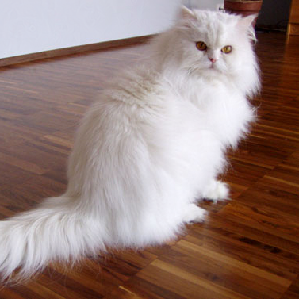

In [8]:
image.array_to_img(original_image[0])

In [9]:
def trick_inception(class_to_fake):
    # Grab a reference to the first and last layer of the neural net
    model_input_layer = model.layers[0].input
    model_output_layer = model.layers[-1].output

    object_type_to_fake = imagenet_classes.index(class_to_fake)
    
    print("Modifying class of image to:",class_to_fake,"( index",object_type_to_fake,")")
    
    # Pre-calculate the maximum change we will allow to the image
    # We'll make sure our hacked image never goes past this so it doesn't look funny.
    # A larger number produces an image faster but risks more distortion.
    max_change_above = original_image + 0.01
    max_change_below = original_image - 0.01

    # Create a copy of the input image to hack on
    hacked_image = np.copy(original_image)
    best_hacked_image = np.copy(original_image)

    # How much to update the hacked image in each iteration
    learning_rate = 0.1  # was 0.01

    # Define the cost function.
    # Our 'target' will be the likelihood of the target class according to the pre-trained model
    target_function = model_output_layer[0, object_type_to_fake]
    # An alternative might be to set a target function 
    # target_function = 2*model_output_layer[0, object_type_to_fake]-K.sum(model_output_layer[0,:])

    # We'll ask Keras to calculate the gradient based on the input image and the currently predicted class
    # In this case, referring to "model_input_layer" will give us back the image we are hacking.
    gradient_function = K.gradients(target_function, model_input_layer)[0]

    # Create a Keras function that we can call to calculate the current cost and gradient
    # grab_cost_and_gradients_from_model = K.function([model_input_layer, K.learning_phase()], [cost_function, gradient_function])

    # 
    grab_target = K.function([model_input_layer, K.learning_phase()],[target_function])
    grab_gradients = K.function([model_input_layer, K.learning_phase()], [gradient_function])

    target = 0.0
    oldTarget = -1
    iterationCount = 0
    # In a loop, keep adjusting the hacked image slightly so that it tricks the model more and more
    while target < 0.85:
        # Check how close the image is to our target class and grab the gradients we
        # can use to push it one more step in that direction.
        # Note: It's really important to pass in '0' for the Keras learning mode here!
        # Keras layers behave differently in prediction vs. train modes!
        gradients = grab_gradients([hacked_image, 0])[0]

        # Move the hacked image one step further towards fooling the model
        hacked_image += (gradients/np.linalg.norm(gradients) * learning_rate)

        iterationCount+=1

        # Ensure that the image doesn't ever change too much to either look funny or to become an invalid image
        hacked_image = np.clip(hacked_image, max_change_below, max_change_above)
        hacked_image = np.clip(hacked_image, -1.0, 1.0)

        target = grab_target([hacked_image, 0])[0]
        if (target-oldTarget > 0.1) or ((iterationCount%10) == 1):
            if (target-oldTarget > 0.1):
                oldTarget = target
                best_hacked_image = np.copy(hacked_image)
            print("Iteration #{}: best target function: {:.8}".format(iterationCount, target))

    # Run the image through the neural network
    predictions = model.predict(best_hacked_image)

    # Convert the predictions into text and print them
    predicted_classes = inception_v3.decode_predictions(predictions, top=3)
    imagenet_id, name, confidence = predicted_classes[0][0]
    
    
    with image_widget:
        print("\nThis is classified as {} with {:.4}% confidence!".format(name, confidence * 100))
        best_hacked_image[0] /= 2.
        best_hacked_image[0] += 0.5
        best_hacked_image[0] *= 255.
        im = Image.fromarray(best_hacked_image[0].astype(np.uint8))
        im.save("hacked_image.png".format(object_type_to_fake))
        display(im)
    
    return 

In [10]:
import json
from urllib.request import urlopen

imagenet_class_index = json.load(urlopen(r"https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"))
imagenet_classes = [imagenet_class_index[str(c)][1] for c in range(len(imagenet_class_index))]

imagenet_classes_widget = widgets.Select(
    options=imagenet_classes,
    value="hammerhead",
    rows=10,
    description="Class to fake:")

start_widget = widgets.Button(description="Click here to start")
start_widget.style.button_color = 'lightgray'

def start_widget_clicked(b):
    log_widget.clear_output()
    image_widget.clear_output()
    with log_widget:
        trick_inception(imagenet_classes_widget.value)

start_widget.on_click(start_widget_clicked)

log_widget = widgets.Output()
log_widget.layout.height = '200px'

image_widget = widgets.Output()

hb = widgets.HBox([imagenet_classes_widget,start_widget,log_widget])
gui = widgets.VBox([hb,image_widget])

# Pick a class and press the grey button

In [11]:
display(gui)

VBox(children=(HBox(children=(Select(description='Class to fake:', index=4, options=('tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 'sidewinder', 'trilobite', 'harvestman', 'scorpion', 'black_and_gold_garden_spider', 'barn_spider', 'garden_spider', 'black_widow', 'tarantula', 'wolf_spider', 'tick', 'centipede', 'black_grouse', 'ptarmigan', 'ruffed_grouse', 'prairie_chicken', 'peacock', 'quail', 'partridge', 'African_grey', 'macaw', 'sulphur-crested_cockatoo', 'lorikeet', 'coucal', 'bee_eater', 'hornbill', 'hummingbird', 'jacamar', 'toucan', 'drake', 'red-breasted_merganser', 'goose', 'black_swan', 'tusker', 'echidna', 'platypus', 'wallaby', 'koala', 'wombat', 'jellyfish', 'sea_anemone', 'brain_coral', 'flatworm', 'nematode', 'conch', 'snail', 'slug', 'sea_slug', 'chiton', 'chambered_nautilus', 'Dungeness_crab', 'rock_crab', 'fiddler_crab', 'king_crab', 'American_lobster', 'spiny_lobster', 'crayfish', 'hermit_crab', 'isopod', 'white_stork', 'black_stork', 'spoonbill', 'flamingo', 'little_blue_heron', 'American_egret', 'bittern', 'crane', 'limpkin', 'European_gallinule', 'American_coot', 'bustard', 'ruddy_turnstone', 'red-backed_sandpiper', 'redshank', 'dowitcher', 'oystercatcher', 'pelican', 'king_penguin', 'albatross', 'grey_whale', 'killer_whale', 'dugong', 'sea_lion', 'Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'flat-coated_retriever', 'curly-coated_retriever', 'golden_retriever', 'Labrador_retriever', 'Chesapeake_Bay_retriever', 'German_short-haired_pointer', 'vizsla', 'English_setter', 'Irish_setter', 'Gordon_setter', 'Brittany_spaniel', 'clumber', 'English_springer', 'Welsh_springer_spaniel', 'cocker_spaniel', 'Sussex_spaniel', 'Irish_water_spaniel', 'kuvasz', 'schipperke', 'groenendael', 'malinois', 'briard', 'kelpie', 'komondor', 'Old_English_sheepdog', 'Shetland_sheepdog', 'collie', 'Border_collie', 'Bouvier_des_Flandres', 'Rottweiler', 'German_shepherd', 'Doberman', 'miniature_pinscher', 'Greater_Swiss_Mountain_dog', 'Bernese_mountain_dog', 'Appenzeller', 'EntleBucher', 'boxer', 'bull_mastiff', 'Tibetan_mastiff', 'French_bulldog', 'Great_Dane', 'Saint_Bernard', 'Eskimo_dog', '

You don't believe this?

Save the image on imgur and run InceptionV3 at: https://transcranial.github.io/keras-js/#/inception-v3


### Some examples
- hammerhead: https://cdn.pbrd.co/images/HdFAu9G.png
- chain: https://cdn.pbrd.co/images/HdFDBFa.png
- espresso: https://cdn.pbrd.co/images/HdG14YE.png
- banded gecko: https://imgur.com/a/tNZv1

In [12]:
o_img = image.load_img("hacked_image.png", target_size=(299, 299))


model_output_layer = model.layers[-1].output
hacked_image = image.img_to_array(o_img)
# Scale the image so all pixel intensities are between [-1, 1] as the model expects
hacked_image /= 255.
hacked_image -= 0.5
hacked_image *= 2.

# Add a 4th dimension for batch size (as Keras expects)
hacked_image = np.expand_dims(hacked_image, axis=0)
predictions = model.predict(hacked_image)

# Convert the predictions into text and print them
predicted_classes = inception_v3.decode_predictions(predictions, top=3)
imagenet_id, name, confidence = predicted_classes[0][0]
print("\nThis is classified as {} with {:.4}% confidence!".format(name, confidence * 100))


This is classified as goldfish with 91.7% confidence!
